In [ ]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import torch
import lightning.pytorch as pl
from src.dataset.dataset import SubCellDatset, DatasetType
from src.model.full_model import SubCellProtModel
from src.utils.analysis_utils import call_model
from src.utils.data_handling_utils import initialize_datasets
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import pickle

In [2]:
COLLECTION_NAME="random_splice_isoform_dataset"
MODEL_CHECKPOINT='checkpoints/splice_isoform_dataset_cell_line_and_gene_split_full-epoch=01-val_combined_loss=0.18.ckpt'


In [3]:
train_dataset, val_dataset, test_dataset, get_data = initialize_datasets(COLLECTION_NAME,if_alphabetical=False)

In [4]:
loaded_model = SubCellProtModel().load_from_checkpoint(
    MODEL_CHECKPOINT,
    collection_name=COLLECTION_NAME,
    batch_size=32,
)

In [7]:



activations = []
metadatas = []
total_datapoints = len(test_dataset)+len(val_dataset)+len(train_dataset)
if os.path.exists(OUTPUT_PKL_FILE):
    embedding_df = pd.read_pickle(OUTPUT_PKL_FILE)
else:
    embedding_df = pd.DataFrame(
        columns=[
            "idx",
            "splice_variant_id",
            "cell_line",
            "cell_image",
            "activation",
            "metadata",
        ]
    )
    embedding_df.set_index('idx', inplace=True)


for cell_idx in tqdm(range(total_datapoints)):
    if len(embedding_df.index.intersection([cell_idx])) > 0:
        continue
    if cell_idx<len(train_dataset):
        curr_dataset=train_dataset
        retrieve_idx=cell_idx
    elif cell_idx<len(val_dataset)+len(train_dataset):
        curr_dataset=val_dataset
        retrieve_idx=cell_idx-len(train_dataset)
    else:
        curr_dataset=test_dataset
        retrieve_idx=cell_idx-len(train_dataset)-len(val_dataset)

    (
        X_esm2_encoding_orig,
        X_protein_len_orig,
        X_landmark_stains_orig,
        _y_multilabel_orig,
        _y_antibody_stain_orig,
    ), cell_line_metadata = curr_dataset.get_item_verbose(retrieve_idx)
    y_pred_multilabel, y_pred_antibody_stain_pred, activation = call_model(
        loaded_model,X_esm2_encoding_orig, X_protein_len_orig, X_landmark_stains_orig, embedding_hooks=['cell_embedding', 'protein_embedding','joint_embedding']
    )
    embedding_df.loc[cell_idx] = pd.Series(
        {
            "cell_line": cell_line_metadata["cell_line"],
            "splice_variant_id": cell_line_metadata["splice_isoform_id"],
            "cell_image": cell_line_metadata["cell_image"]["nuclei_channel"],
            "activation": activation,
            "metadata": cell_line_metadata,
            "y_pred_multilabel": y_pred_multilabel,
            "y_pred_antibody_stain_pred": y_pred_antibody_stain_pred.detach().numpy(),
        }
    )
    if cell_idx % 1000 == 0:
        embedding_df.to_pickle(OUTPUT_PKL_FILE)


100%|████████████████████████████████████| 29909/29909 [01:06<00:00, 450.02it/s]


In [8]:
embedding_df.to_pickle(OUTPUT_PKL_FILE)

In [6]:
embedding_df = pd.read_pickle(OUTPUT_PKL_FILE)

### PCA of protein embedding

In [7]:
#PCA of protein embedding
sv_unique,sv_idx=np.unique(embedding_df['splice_variant_id'],return_index=True)
sv_embedding=np.zeros((sv_unique.size,embedding_df['activation'][0]['protein_embedding'].size()[1]))
sv_location=np.zeros(sv_unique.size).astype(str)

In [8]:
for sv_i in range(sv_unique.size):
    sv_embedding[sv_i]=embedding_df['activation'][sv_idx[sv_i]]['protein_embedding'].numpy().flatten()
    sv_location[sv_i]=embedding_df['metadata'][sv_idx[sv_i]]['location_labels']

In [9]:
pca_sv=PCA(n_components=50)
pca_sv.fit(sv_embedding)
sv_pca=pca_sv.transform(sv_embedding)

In [14]:
plotting_df = pd.DataFrame(
    {"sv_name":sv_unique,
     'sv_location':sv_location,
     "Proteoform PC1":sv_pca[:,0],
     "Proteoform PC2":sv_pca[:,1],
    }
)

In [1]:
def show_embedding(plotting_df, x_lab='PC1', y_lab='PC2', hue_lab='labels',savepath=None):
    hue_order = sorted(set(plotting_df[hue_lab]))
    ax = sns.scatterplot(
        data=plotting_df,
        x=x_lab,
        y=y_lab,
        style=hue_lab,
        hue=hue_lab,
        hue_order=hue_order,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    if savepath is None:
        plt.show()
    else:
        plt.tight_layout()
        plt.savefig(savepath,dpi=600)

In [11]:
sv_locNuc=np.repeat('',sv_location.size).astype('U20')
for sv_i in range(sv_locNuc.size):
    if 'Cytosol' in sv_location[sv_i]:
        sv_locNuc[sv_i]=sv_locNuc[sv_i]+'Cytosol'
    if 'Nucleoplasm' in sv_location[sv_i]:
        sv_locNuc[sv_i]=sv_locNuc[sv_i]+'Nucleoplasm'
sv_locNuc[sv_locNuc=='']='other'

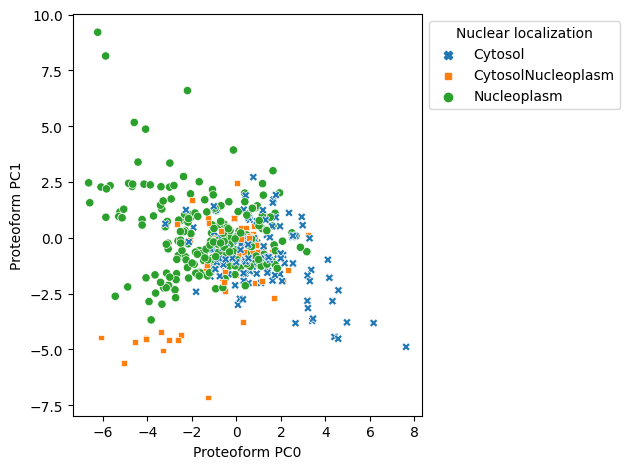

In [12]:
pc1=0
pc2=1
plotting_df = pd.DataFrame(
    {"Nuclear localization":sv_locNuc[sv_locNuc!='other'],
     "Proteoform PC"+str(pc1):sv_pca[sv_locNuc!='other',pc1],
     "Proteoform PC"+str(pc2):sv_pca[sv_locNuc!='other',pc2],
    }
)
show_embedding(plotting_df,'Proteoform PC'+str(pc1),'Proteoform PC'+str(pc2),'Nuclear localization','results/p_pca_random.jpg')